# Freeswitch Log Traffic Analysis

## Altanai Bisht 
( abisht@seattleu.edu
altanai.telecom.com)

License GPL 3

In [190]:
import os 
os.environ['JAVA_HOME']="C:\\Users\\abisht\\.jdks\\corretto-11.0.15"
print(os.environ['JAVA_HOME'])

C:\Users\abisht\.jdks\corretto-11.0.15


In [191]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\abisht\\Downloads\\spark-3.2.1-bin-hadoop3.2\\spark-3.2.1-bin-hadoop3.2'

In [194]:
from datetime import datetime, date
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [193]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics 
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()

# Call Record

FreeSWITCH CDRs stored in /usr/local/freeswitch/log/cdr-csv/Master.csv
ref : https://freeswitch.org/confluence/display/FREESWITCH/CDR
and https://freeswitch.org/confluence/display/FREESWITCH/mod_cdr_csv

In [17]:
# logfile = "/fslogs/*.log"
# fslogs = sc.textFile("hdfs://localhost:9000/"+logfile)
filepath= "C:\\Users\\abisht\\VoIPCallLogs_BigDataSet\\freeswitch\\*.log"

from pyspark import SparkFiles
base_df = spark.read.text(SparkFiles.get(filepath))

Example Freeswitch cdr-csv log line:
"8001","8001","0046423112856","public","2020-06-13 00:58:52","2020-06-13 00:58:52","2020-06-13 00:58:53","1","1","USER_NOT_REGISTERED","f2b05a36-ace2-11ea-aa3b-153da8caf925","","","PCMU","PCMU"

FS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+)'

In [195]:
base_df.head()

Row(value='2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log')

In [196]:
base_df.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log                                                |
|2020-06-14 05:05:07.622623 [DEBUG] sofia_reg.c:1790 Send challenge for [9999@117.201.85.75]                                                                    |
|2020-06-14 05:05:07.622623 [WARNING] sofia_reg.c:1794 SIP auth challenge (REGISTER) on sofia profile 'internal' for [9999@117.201.85.75] from ip 37.187.153.237|
|send 618 bytes to udp/[37.1

In [21]:
base_df.columns
type(base_df)

pyspark.sql.dataframe.DataFrame

In [22]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

## Data Wrangling


In [23]:
print((base_df.count(), len(base_df.columns)))

(7519512, 1)


In [35]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log',
 '2020-06-14 05:05:07.622623 [DEBUG] sofia_reg.c:1790 Send challenge for [9999@117.201.85.75]',
 "2020-06-14 05:05:07.622623 [WARNING] sofia_reg.c:1794 SIP auth challenge (REGISTER) on sofia profile 'internal' for [9999@117.201.85.75] from ip 37.187.153.237",
 'send 618 bytes to udp/[37.187.153.237]:6275 at 03:08:15.775434:',
 '------------------------------------------------------------------------',
 'SIP/2.0 401 Unauthorized',
 'Via: SIP/2.0/UDP 37.187.153.237:6275;branch=z9hG4bK-3405921800;rport=6275',
 'From: "9999" <sip:9999@117.201.85.75>;tag=2930930192',
 'To: "9999" <sip:9999@117.201.85.75>;tag=2Z3F1yFBKrvDp',
 'Call-ID: 1834515944',
 'CSeq: 1 REGISTER',
 'User-Agent: FreeSWITCH-mod_sofia/1.10.4-dev+git~20200518T172205Z~91f54340ed~64bit',
 'Allow: INVITE, ACK, BYE, CANCEL, OPTIONS, MESSAGE, INFO, UPDATE, REGISTER, REFER, NOTIFY, PUBLISH, SUBSCRIBE',
 'Supported: 

## Reframe the dataframe with regex

Extracting timestamps

In [197]:
# 2020-06-14 05:05:07.622623
ts_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})'

In [198]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', ts_pattern, 1).alias('timestamp'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+-------------------+
|          timestamp|
+-------------------+
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
+-------------------+
only showing top 10 rows

(7519512, 1)


## Finding missing values, Drop or values outside of date range 

In [199]:
(base_df
    .filter(base_df['value'].isNull())
    .count())

0

In [112]:
dates = ("2019-01-01",  "2022-12-31")
# bad_rows_df = logs_df['timestamp'].between(*dates).show(truncate=False)
useful_logs_df= logs_df.select(logs_df['timestamp'], logs_df['timestamp'].between(*dates))
useful_logs_df.count()

961775

In [113]:
logs_df = useful_logs_df[useful_logs_df[1]=='true']
logs_df.show(10, truncate=True)

+-------------------+---------------------------------------------------------+
|          timestamp|((timestamp >= 2019-01-01) AND (timestamp <= 2022-12-31))|
+-------------------+---------------------------------------------------------+
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                   

In [115]:
new_rdd = logs_df.rdd

In [116]:
from pyspark.sql import Row
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df2 = spark.createDataFrame(parsed_rdd)

In [119]:
df2.count()

961775

In [120]:
df2.printSchema()

root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [121]:
df2.show(1, vertical=True)

-RECORD 0------------------------
 startTime | 2020-06-14 05:05:07 
 endTime   | 2020-06-14 05:05:07 
 calluuid  | 2020-06-14 05:05:07 
only showing top 1 row



### Number of unique daily Request reponse network traffic 

In [129]:
from pyspark.sql import functions as F

# find the day of the month
daily_traffic_df = df2.select(df2['startTime'], F.dayofmonth('startTime').alias('day'))
daily_traffic_df.show(5, truncate=False)

+-------------------+---+
|startTime          |day|
+-------------------+---+
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
+-------------------+---+
only showing top 5 rows



In [130]:
# Count of calls per day
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_df = (daily_traffic_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_df = daily_df.toPandas()
daily_df

,day,count
0,2,17289
1,14,890041
2,18,31
3,19,3140
4,20,1594
...,...,...
6,22,11067
7,23,4168
8,26,1264
9,27,1268


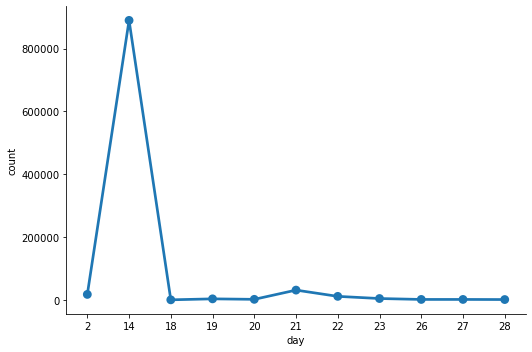

In [131]:
c = sns.catplot(x='day', y='count',
                data=daily_df,
                kind='point', height=5,
                aspect=1.5)

## Hourly normal clearings

In [142]:
# # find the day of the month
# hourly_traffic_df = df2.select(df2['startTime'], F.hour('startTime').alias('hour'))
# hourly_traffic_df.show(5, truncate=False)

In [173]:
# Count of calls per hour

from pyspark.sql.functions import col, count, date_format, date_sub, date_trunc, month, next_day, to_timestamp, weekofyear, window, year

def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

hourly_df = (daily_traffic_df
                     .select(F.date_format('startTime','yyyy-MM-dd hh:mm:ss').alias('timestamp'))
                     .groupBy(window('timestamp', "15 minutes"))
                     .count())
# hourly_df= hourly_df.groupBy('startTime', window('startTime', "5 minutes")).sum("metric")

hourly_df = hourly_df.toPandas()
hourly_df

,window,count
0,"(2020-06-14 05:00:00, 2020-06-14 05:15:00)",144305
1,"(2020-06-14 05:15:00, 2020-06-14 05:30:00)",195354
2,"(2020-06-14 05:30:00, 2020-06-14 05:45:00)",37080
3,"(2020-06-14 06:30:00, 2020-06-14 06:45:00)",33174
4,"(2020-06-14 06:00:00, 2020-06-14 06:15:00)",41448
...,...,...
138,"(2020-06-14 04:30:00, 2020-06-14 04:45:00)",4364
139,"(2022-03-21 02:15:00, 2022-03-21 02:30:00)",107
140,"(2022-03-22 08:30:00, 2022-03-22 08:45:00)",291
141,"(2022-03-20 01:15:00, 2022-03-20 01:30:00)",940


In [185]:
window_start = hourly_df['window'].map(lambda r : Row(start =r[0]))
window_start= spark.createDataFrame(window_start).toPandas()
hourly_df["start"]=window_start
hourly_df.drop(columns=["window"], inplace=True)
hourly_df

,count,start
0,144305,2020-06-14 05:00:00
1,195354,2020-06-14 05:15:00
2,37080,2020-06-14 05:30:00
3,33174,2020-06-14 06:30:00
4,41448,2020-06-14 06:00:00
...,...,...
138,4364,2020-06-14 04:30:00
139,107,2022-03-21 02:15:00
140,291,2022-03-22 08:30:00
141,940,2022-03-20 01:15:00


<Figure size 720x360 with 0 Axes>

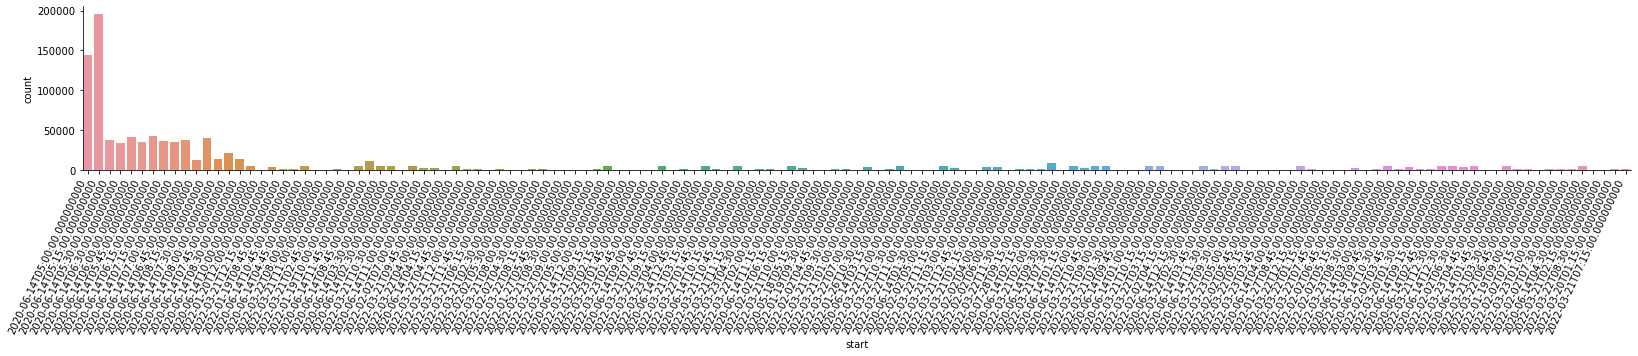

In [186]:
plt.figure(figsize=(10,5))
chart = sns.catplot(x='start', y='count',
                data=hourly_df,
                kind='bar', height=3, aspect=8)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

# Carbon Footprint

In [188]:
import carbonfootprint as carbonfp
# from carbonfp.power_utilities.carbon import Carbon
# from power_utilities.fuelmix import Fuelmix
# # from power_utilities.Fuelmix import calculate_fuelmixbypercent
# # from power_utilities import carbon_by_fuelmix
# from power_utilities import fuelmix
carbonfp

In [189]:
# for importer, modname, ispkg in carbonfp(path=None, onerror=lambda x: None):
#     print(modname)

for importer, modname, ispkg in carbonfp.iter_modules(package.__path__):
    print("Found submodule %s (is a package: %s)" % (modname, ispkg))

AttributeError: module 'carbonfootprint' has no attribute 'iter_modules'

In [ ]:
furlpercent_obj = carbonfp.power_utilities.Fuelmix("north_west")

In [ ]:

dfindus_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(dfindus_hourly)
carbonemissio_pbj = Carbon()
dfindus_hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(dfindus_hourly_fuelmix)
print("-------------dfindus_hourly_fuelmix_carbon------------------")
print(dfindus_hourly_fuelmix_carbon.head())
print(dfindus_hourly_fuelmix_carbon.columns)


**Refs**
- https://opensource.com/article/19/5/visualize-log-data-apache-spark